In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob, os
import csv
from datetime import datetime

import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import DataLoader, TensorDataset
import tqdm         # make loops show as a smart progress meter

from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from datetime import datetime
import os

In [3]:
# Classic_Model (Ortho, ReLu, SoftMax and bias)========================================================================================================
# Variable is added to the name because layers and neurons can now be chosen
class ClassicalVariableModel(nn.Module):
    def __init__(self, input_size=4, hidden_sizes=[8, 8], output_size=3):
        """
        input_size: number of input features (e.g. 4 for Iris)
        hidden_sizes: list of hidden layer sizes, e.g. [8, 8, 4]
        output_size: number of output classes (e.g. 3 for Iris)
        """
        super(ClassicalVariableModel, self).__init__()
        
        # Create a list of layer sizes
        layer_sizes = [input_size] + hidden_sizes + [output_size]
        
        # Create a list of Linear layers
        self.layers = nn.ModuleList([
            nn.utils.parametrizations.orthogonal(nn.Linear(layer_sizes[i], layer_sizes[i+1]))
            for i in range(len(layer_sizes) - 1)
        ])

    def forward(self, x):
        # Go through all layers except the last one with ReLU
        for layer in self.layers[:-1]:
            x = F.relu(layer(x))
        # Apply softmax on the last layer (output)
        x = F.softmax(self.layers[-1](x), dim=1)
        return x

In [4]:
# Classic_Model_No_Biases (Ortho, Relu, SoftMax and No bias) ========================================================================================================
class ClassicalVariableModel_NoBiases(nn.Module):
    def __init__(self, input_size=4, hidden_sizes=[8, 8], output_size=3):
        """
        input_size: number of input features (e.g. 4 for Iris)
        hidden_sizes: list of hidden layer sizes, e.g. [8, 8, 4]
        output_size: number of output classes (e.g. 3 for Iris)
        """
        super(ClassicalVariableModel_NoBiases, self).__init__()
        
        # Create a list of layer sizes
        layer_sizes = [input_size] + hidden_sizes + [output_size]
        
        # Create a list of Linear layers
        self.layers = nn.ModuleList([
            nn.utils.parametrizations.orthogonal(nn.Linear(layer_sizes[i], layer_sizes[i+1]))
            for i in range(len(layer_sizes) - 1)
        ])

    def forward(self, x):
        # Go through all layers except the last one with ReLU
        for layer in self.layers[:-1]:
            x = F.relu(layer(x))
        # Apply softmax on the last layer (output)
        x = F.softmax(self.layers[-1](x), dim=1)
        return x

In [9]:
# Classic_Model_NoRelu (Ortho, no ReLu,SoftMax, bias)========================================================================================================
class LinearVariableModel_NoRelu(nn.Module):
    def __init__(self, input_size=4, hidden_sizes=[8, 8], output_size=3):
        """
        input_size: number of input features (e.g. 4 for Iris)
        hidden_sizes: list of hidden layer sizes, e.g. [8, 8, 4]
        output_size: number of output classes (e.g. 3 for Iris)
        """
        super(ClassicalVariableModel_Relu, self).__init__()
        
        # Create a list of layer sizes
        layer_sizes = [input_size] + hidden_sizes + [output_size]
        
        # Create a list of Linear layers
        self.layers = nn.ModuleList([
            nn.utils.parametrizations.orthogonal(nn.Linear(layer_sizes[i], layer_sizes[i+1]))
            for i in range(len(layer_sizes) - 1)
        ])

    def forward(self, x):
        # Go through all layers except the last one with ReLU
        for layer in self.layers[:-1]:
            x = layer(x)
        # Apply softmax on the last layer (output)
        x = F.softmax(self.layers[-1](x), dim=1)
        return x

In [6]:
class train_backprop():

    def __init__(self) -> None:
        iris = load_iris()
        X = iris['data']
        y = torch.tensor(iris['target'], dtype=torch.long)

        scaler = StandardScaler()
        X_scaled = torch.tensor(scaler.fit_transform(X), dtype=torch.float)

        X_train, X_test, y_train, y_test = train_test_split(
            X_scaled, y, test_size=0.2, random_state=2)  # Total n dat 150, so 120 for train and 30 for test

        self.train_data = TensorDataset(X_train, y_train)
        test_data = TensorDataset(X_test, y_test)

        self.train_loader = DataLoader(self.train_data, shuffle=True, batch_size=12)  # batch size 12 so 10 batch
        self.test_loader = DataLoader(test_data, batch_size=len(test_data.tensors[0]))  # batch size 30 max

    def train_IRIS(self,
                   model,
                   epochs: int = 400) -> [np.array, np.array, np.array, np.array]:

        optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
        loss_fn = nn.CrossEntropyLoss()

        train_loss = np.zeros(epochs)
        valid_loss = np.zeros(epochs)
        train_accuracy = np.zeros(epochs)
        valid_accuracy = np.zeros(epochs)

        for epoch in tqdm.trange(epochs):
            # Train
            for X, y in self.train_loader:
                y_pred = model(X)
                loss = loss_fn(y_pred, y)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            # Test training data
            with torch.no_grad():
                X, y = self.train_data[:]
                y_pred = model(X)
                loss = loss_fn(y_pred, y)
                train_loss[epoch] = loss.item()
                y_pred_labels = torch.argmax(y_pred, axis=1)
                train_accuracy[epoch] = torch.mean((y_pred_labels == y).float()).item()

            # Validation
            with torch.no_grad():
                X, y = next(iter(self.test_loader))
                y_pred = model(X)
                loss = loss_fn(y_pred, y)
                valid_loss[epoch] = loss.item()
                y_pred_labels = torch.argmax(y_pred, axis=1)
                valid_accuracy[epoch] = torch.mean((y_pred_labels == y).float()).item()

        return train_loss, valid_loss, train_accuracy, valid_accuracy

    def graph_train_IRIS(self, model, epochs: int = 400, n_runs: int = 15) -> None:
        """
        Train the given model multiple times (n_runs) and save all results in a single CSV file.
        The CSV includes model name, hidden layer configuration, and final metrics for each run.
        Only the final run displays the training graph.
        """
        import os
        from datetime import datetime
        import pandas as pd
        import matplotlib.pyplot as plt

        os.makedirs("results", exist_ok=True)

        model_name = model.__class__.__name__

        # Detect hidden layer sizes if possible
        try:
            hidden_sizes = [layer.out_features for layer in model.layers[:-1]]
        except AttributeError:
            hidden_sizes = ["Unknown"]

        # Use timestamp of the first run for filename
        global_timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        all_runs = []  # store all runs here

        for run in range(1, n_runs + 1):
            model = model.__class__()  # re-instantiate model for each run
            print(f"🚀 Run {run}/{n_runs} for {model_name} with layers {hidden_sizes}")

            train_loss, valid_loss, train_accuracy, valid_accuracy = self.train_IRIS(model, epochs)

            final_train_loss = train_loss[-1]
            final_valid_loss = valid_loss[-1]
            final_train_acc = train_accuracy[-1]
            final_valid_acc = valid_accuracy[-1]

            all_runs.append({
                "timestamp": global_timestamp,
                "model_name": model_name,
                "hidden_sizes": str(hidden_sizes),
                "epochs": epochs,
                "run_number": run,
                "final_train_loss": final_train_loss,
                "final_valid_loss": final_valid_loss,
                "final_train_accuracy": final_train_acc,
                "final_valid_accuracy": final_valid_acc
            })

            print(f"🏁 Validation accuracy (run {run}): {final_valid_acc:.3f}")

            # Show the training curves only for the last run
            if run == n_runs:
                fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
                ax1.plot(train_accuracy, label="Train accuracy")
                ax1.plot(valid_accuracy, label="Validation accuracy")
                ax1.set_title("Accuracy")
                ax1.set_xlabel("epochs")
                ax1.set_ylim([0.0, 1.05])
                ax1.legend()

                ax2.plot(train_loss, label="Train loss")
                ax2.plot(valid_loss, label="Validation loss")
                ax2.set_title("Loss")
                ax2.set_xlabel("epochs")
                ax2.legend()
                plt.show()

        # Save all results after all runs
        results_df = pd.DataFrame(all_runs)
        csv_filename = f"{model_name}_layers{hidden_sizes}_epochs{epochs}_{n_runs}runs_{global_timestamp}.csv"
        csv_path = os.path.join("results", csv_filename)
        results_df.to_csv(csv_path, index=False)

        print(f"\n✅ All {n_runs} runs saved in one file → {csv_path}")






    



🚀 Run 1/15 for ClassicalVariableModel with layers [2]


100%|██████████| 400/400 [00:16<00:00, 24.41it/s]


🏁 Validation accuracy (run 1): 0.867
🚀 Run 2/15 for ClassicalVariableModel with layers [2]


100%|██████████| 400/400 [00:17<00:00, 22.43it/s]


🏁 Validation accuracy (run 2): 0.867
🚀 Run 3/15 for ClassicalVariableModel with layers [2]


100%|██████████| 400/400 [00:17<00:00, 22.52it/s]


🏁 Validation accuracy (run 3): 0.867
🚀 Run 4/15 for ClassicalVariableModel with layers [2]


100%|██████████| 400/400 [00:20<00:00, 19.87it/s]


🏁 Validation accuracy (run 4): 0.867
🚀 Run 5/15 for ClassicalVariableModel with layers [2]


100%|██████████| 400/400 [00:20<00:00, 19.83it/s]


🏁 Validation accuracy (run 5): 0.867
🚀 Run 6/15 for ClassicalVariableModel with layers [2]


100%|██████████| 400/400 [00:20<00:00, 19.76it/s]


🏁 Validation accuracy (run 6): 0.867
🚀 Run 7/15 for ClassicalVariableModel with layers [2]


100%|██████████| 400/400 [00:19<00:00, 20.07it/s]


🏁 Validation accuracy (run 7): 0.867
🚀 Run 8/15 for ClassicalVariableModel with layers [2]


100%|██████████| 400/400 [00:19<00:00, 20.78it/s]


🏁 Validation accuracy (run 8): 0.867
🚀 Run 9/15 for ClassicalVariableModel with layers [2]


100%|██████████| 400/400 [00:20<00:00, 19.48it/s]


🏁 Validation accuracy (run 9): 0.867
🚀 Run 10/15 for ClassicalVariableModel with layers [2]


100%|██████████| 400/400 [00:18<00:00, 21.12it/s]


🏁 Validation accuracy (run 10): 0.867
🚀 Run 11/15 for ClassicalVariableModel with layers [2]


100%|██████████| 400/400 [00:18<00:00, 22.20it/s]


🏁 Validation accuracy (run 11): 0.867
🚀 Run 12/15 for ClassicalVariableModel with layers [2]


100%|██████████| 400/400 [00:17<00:00, 22.23it/s]


🏁 Validation accuracy (run 12): 0.867
🚀 Run 13/15 for ClassicalVariableModel with layers [2]


100%|██████████| 400/400 [00:24<00:00, 16.07it/s]


🏁 Validation accuracy (run 13): 0.867
🚀 Run 14/15 for ClassicalVariableModel with layers [2]


100%|██████████| 400/400 [00:19<00:00, 20.39it/s]


🏁 Validation accuracy (run 14): 0.867
🚀 Run 15/15 for ClassicalVariableModel with layers [2]


100%|██████████| 400/400 [00:19<00:00, 20.42it/s]


🏁 Validation accuracy (run 15): 0.867


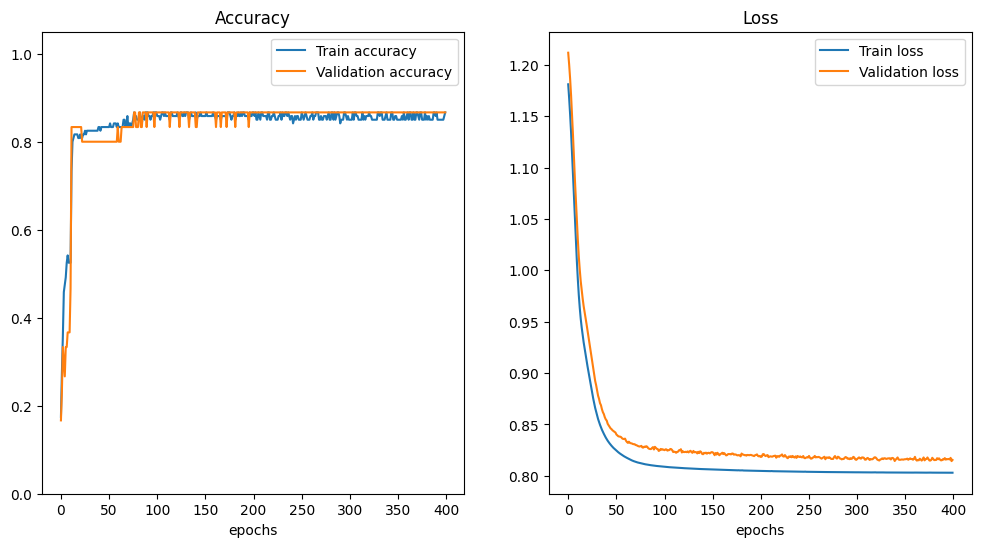


✅ All 15 runs saved in one file → results\ClassicalVariableModel_layers[2]_epochs400_15runs_20251125_191733.csv


In [ ]:
a = train_backprop()
# train_loss, valid_loss, train_accuracy, valid_accuracy = a.train_IRIS(Classic_Model())
a.graph_train_IRIS(ClassicalVariableModel(hidden_sizes=[3,3]))

